In [1]:
# !pip install matplotlib
# !pip install pandas
# !pip install numpy
# !pip install openpyxl

In [2]:
# 자기소개서 데이터 RAW와 label 분리 (다중 분류 임)
# 점수 구현은 따로 구현(GPT로 post-processing)

In [3]:
import os
import re
import json
from tqdm import tqdm

import pandas as pd
import numpy as np

from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from transformers import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.metrics import accuracy_score


/home/najo/.conda/envs/test_20240708/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0, 1, 2"  # Set the GPUs 2 and 3 to use

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

torch.cuda.manual_seed_all(42)

Device: cuda
Current cuda device: 0
Count of using GPUs: 3


In [5]:
# 파일 불러오고 df에 저장(raw_text 특수문자 제거)

file_path = "/home/najo/NAS/ONLAB/ONLAB_Competency/2024-10-15"
file_name = [f for f in os.listdir(file_path) if f.endswith('.json')]

df = pd.DataFrame(columns=['raw_text', 'class'])

# 주어진 레이블을 원-핫 인코딩으로 변환하는 함수
def multi_label_to_one_hot(labels, num_classes):
    one_hot = np.zeros(num_classes, dtype=int)
    for label in labels:
        if label < num_classes:  # 레이블이 클래스의 총 개수를 넘지 않도록 확인
            one_hot[label - 1] = 1  # 인덱스는 0부터 시작하므로 레이블-1로 변환
    return one_hot

count = 0
for i in tqdm(file_name):
    with open(os.path.join(file_path, i), 'r', encoding='utf-8') as file:  # Use 'r' mode for reading text files
        data = json.load(file)
        
        for idx in data['anno_text_data']['data']:
            classes = []
            n_class = list(filter(None, idx['class'].split(",")))
            for n in n_class:
                count += 1
                classes.append(int(n))
            one_hot_encoded = multi_label_to_one_hot(classes, 21)
            df.loc[count, 'raw_text'] = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", idx['raw'])
            df.loc[count, 'class'] = one_hot_encoded

print(df)


  3%|▎         | 186/6011 [00:00<00:03, 1851.90it/s]

100%|██████████| 6011/6011 [00:04<00:00, 1294.60it/s]

                                                raw_text  \
1      아버지에게서 배운 성실성과 소통 능력\n\n평소 꾸준함과 성실함을 강조하시던 부모님...   
4      저는 루틴이 가진 강력한 힘을 알고 이용할 줄 압니다 루틴이란 규칙적으로하는 일의 ...   
5      코로나 사태로 세계 경제 시장은 더욱 악화되고 있지만 국내 생산거점을 기반으로 내실...   
6      저는 석사과정 중 세라믹 섬유용 전구체 합성 분야의 차별화된 연구 역량을 키우기 위...   
7      삼성전기는 스마트폰을 비롯한 주요 IT기기 자동차 부품과 네트워크를 제조하는 고객사...   
...                                                  ...   
16654   빠르게 변화하는 시대에 앞서는 KMAC의 디지털 고숙련 실무인재 양성에 매력을 느...   
16655  설득을 무기로 차와 스페셜티 시장 점령\n\n식품은 소비자의 가치관을 가장 잘 반영...   
16658  저는 기업 니즈를 기반으로 한 영업을 통해 6개 기업을 설득했습니다 대학생 동아리 ...   
16659  영업은 고객과 같이 성장하는 직무입니다 고객의 성공이 관계 유지를 가져오기 때문입니...   
16660  세계적으로 선진국들은 점차 환경규제를 강화하고 있는 추세이며 유럽연합에서는 이미 상...   

                                                   class  
1      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...  
4      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...  
5      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...  
6      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [6]:
df.iloc[2000][1]

/tmp/ipykernel_2883296/1908635272.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.iloc[2000][1]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [7]:
# df['class'].value_counts()
type(df['class'][1])
# df['raw_text'] = df['raw_text'].astype(str)
# df['class'] = df['class'].astype(float)
print(df.dtypes)

raw_text    object
class       object
dtype: object


In [8]:
# KLUE-RoBERTa 모델과 토크나이저 로드
model_name = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=21, problem_type="multi_label_classification")

/home/najo/.conda/envs/test_20240708/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index, 0]
        label = self.data.iloc[index, 1]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

max_len = 128
train_dataset = CustomDataset(df, tokenizer, max_len)


In [10]:
next(iter(train_dataset))

{'input_ids': tensor([    0,  4096,  2170,  2318,  2112,  8174,  7658,  2047,  2145,  4740,
          4053,  5076,  5160,  2530,  2145,  7658,  2530,  2069,  3986,  2205,
          2067,  2414,  4267,  2098,  2073,  1545,  2116,  2227,  2540,  2444,
          3804,  2052,   859,  2015,  2138,  4156,  3011,  2219,  3606,  4096,
          2678,  2112,  2259,  1535,  2170,  2318,  4408,  7796,  2069,  4735,
          2205,  3011,  2088,  1535,  2259,  4885,  4622,    25, 18458,  3797,
          5868,  7193,  1537,  3610,  4709,  4408,  3815,  2069,  1889,  2507,
          2219,  3606,  8345,  3644,  1535,  2259,  7658,  2047,  2145,  4740,
          2526,  2069, 12535,  1295,  1513,  2359,  2219,  3606,     2,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [11]:
# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    
# BCEWithLogitsLoss 설정 (multi-label classification용)
loss_fn = nn.BCEWithLogitsLoss()

# 모델 학습 함수
def train_epoch(model, data_loader, optimizer, device):
    model = model.train()
    total_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device)  # 레이블을 float형으로 변환 (필수)

        # 모델의 출력에서 loss 추출
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # loss 계산
        loss = loss_fn(logits, labels)
        
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    return total_loss / len(data_loader)

# 모델 저장 함수 (DataParallel 지원)
def save_model(model, optimizer, epoch, loss, file_name):
    save_path = f"/home/najo/NAS/ONLAB/ONLAB_Competency/Saved_model/{file_name}.pth"
    
    # DataParallel로 감싸져 있는 모델을 저장할 때는 model.module로 접근
    if isinstance(model, torch.nn.DataParallel):
        model_to_save = model.module
    else:
        model_to_save = model
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model_to_save.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, save_path)
    
    print(f"Model saved as {save_path}")

# GPU 설정
model = model.to(device)
model = nn.DataParallel(model)

# 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=5e-5)

# 학습 루프
epochs = 100
best_loss = float('inf')  # 최소 손실을 추적하기 위한 변수
for epoch in range(epochs):
    if epoch % 5 == 0:
        train_loss = train_epoch(model, train_loader, optimizer, device)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss}")

        # 손실이 이전 손실보다 작으면 모델 저장
        if train_loss < best_loss:
            best_loss = train_loss
            # 손실 값을 파일명에 포함, 소수점 5자리까지 사용
            file_name = f"model_loss_{best_loss:.5f}"
            save_model(model, optimizer, epoch, best_loss, file_name)
    else:
        pass


/home/najo/.conda/envs/test_20240708/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


KeyboardInterrupt: 

In [12]:
from sklearn.metrics import f1_score

# BCEWithLogitsLoss 설정
loss_fn = nn.BCEWithLogitsLoss()

# 평가 함수 (multi-label classification에 맞게 수정)
def eval_model(model, data_loader, device):
    model = model.eval()
    total_loss = 0
    all_predictions = []
    all_true_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].float().to(device)  # 레이블을 float으로 변환
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # 시그모이드 적용하여 각 클래스에 대한 확률을 계산
            probs = torch.sigmoid(logits)
            
            # 특정 기준(예: 0.5)을 넘으면 1로 예측
            preds = (probs > 0.5).float()

            # 손실 계산
            loss = loss_fn(logits, labels)
            total_loss += loss.item()
            
            all_predictions.append(preds.cpu().numpy())
            all_true_labels.append(labels.cpu().numpy())

    # 평가 지표 계산 (여기서는 F1-Score를 사용)
    all_predictions = np.vstack(all_predictions)
    all_true_labels = np.vstack(all_true_labels)
    
    f1 = f1_score(all_true_labels, all_predictions, average='macro')  # 매크로 F1 스코어 사용
    
    return total_loss / len(data_loader), f1

# 저장된 모델 불러오기 함수
def load_best_model(model, optimizer, device, file_path):
    checkpoint = torch.load(file_path)
    
    # DataParallel로 감싸진 경우에도 model.module로 저장되었는지 확인
    if isinstance(model, torch.nn.DataParallel):
        model.module.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint['model_state_dict'])
    
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    model = model.to(device)  # 모델을 다시 GPU로 보냄
    print(f"Loaded model from {file_path}, Epoch: {epoch}, Loss: {loss:.5f}")
    
    return model, optimizer

# 저장된 모델 파일 중에서 가장 작은 손실 값을 가진 모델 파일을 찾는 함수
def find_best_model_file(model_dir):
    best_loss = float('inf')
    best_model_file = None
    
    # 모델 파일명을 탐색하고, 손실값이 포함된 파일명을 파싱하여 최소 손실값을 찾음
    for file_name in os.listdir(model_dir):
        if file_name.endswith(".pth"):
            # 파일명에서 손실 값을 추출 (예: model_loss_0.12345.pth에서 0.12345 추출)
            match = re.search(r'model_loss_([\d.]+)\.pth', file_name)
            if match:
                loss = float(match.group(1))
                if loss < best_loss:
                    best_loss = loss
                    best_model_file = file_name
    
    if best_model_file:
        print(f"Best model found: {best_model_file} with loss {best_loss:.5f}")
    else:
        print("No valid model files found.")
    
    return best_model_file

# 저장된 최적의 모델 불러오기 및 평가 함수는 그대로
def evaluate_best_model(model, optimizer, data_loader, device, model_dir):
    best_model_file = find_best_model_file(model_dir)
    
    if best_model_file:
        file_path = os.path.join(model_dir, best_model_file)
        model, optimizer = load_best_model(model, optimizer, device, file_path)
        
        # 모델 평가
        val_loss, val_f1 = eval_model(model, data_loader, device)
        print(f'Validation Loss: {val_loss:.4f}, F1-Score: {val_f1:.4f}')
    else:
        print("No model file to evaluate.")

# 검증 데이터 로더로 변경하는 것이 일반적
best_model_path = "/home/najo/NAS/ONLAB/ONLAB_Competency/Saved_model"

# 학습 후 검증 데이터 평가
evaluate_best_model(model, optimizer, train_loader, device, best_model_path)  # 평가할 때는 val_loader 사용을 권장


Best model found: model_loss_0.01375.pth with loss 0.01375


/tmp/ipykernel_2883296/3691781199.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Loaded model from /home/najo/NAS/ONLAB/ONLAB_Competency/Saved_model/model_loss_0.01375.pth, Epoch: 95, Loss: 0.01375
Validation Loss: 0.0106, F1-Score: 0.9341


/home/najo/.conda/envs/test_20240708/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
# 새로운 텍스트에 대해 예측 함수 (저장된 모델을 불러와 예측)
def predict(text, model, tokenizer, max_len, device, model_dir):
    # 가장 낮은 loss 값을 가진 모델 파일 찾기
    best_model_file = find_best_model_file(model_dir)
    
    if best_model_file is None:
        raise ValueError("No valid model file found.")
    
    model_path = os.path.join(model_dir, best_model_file)
    
    # 모델을 저장된 상태로 불러오기
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)  # 옵티마이저 임시 생성
    model, optimizer = load_best_model(model, optimizer, device, model_path)

    # 입력 텍스트를 토크나이저로 인코딩
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        # 멀티 라벨 분류에서는 시그모이드 함수 적용 후, 임계값 기준으로 0/1 결정
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()  # 0.5 이상의 확률을 가진 경우 1로 예측
    
    return preds.cpu().numpy()  # 예측된 결과를 numpy 배열로 변환

# 예측 사용 예시
sample_text1 = "기재한 역량 및 기술 중 한 가지 이상을 선택하고 그러한 역량 및 기술을 적극적으로 활용했던 경험 또는 이를 습득하기까지의 과정을 기술하여 주십시오.\n\n\"업무 추진력의 바탕 : 세밀한 기획\"\n\n인문학 교실을 기획하고 운영하는 프로그램 당시, 일정이 바뀌어 인턴십이 겹치고 하차 인원이 생겨 인력, 시간이 부족했고 이를 극복하기 위해 다음과 같이 행동했습니다.\n\n첫째, 진행된 과제 상황을 파악하고 앞으로 해야 할 일과 사용 가능한 시간을 리스트로 만들었습니다. 그리고 우선순위에 따라 시간을 배분한 후 추가적으로 필요한 시간을 확인했습니다.\n\n둘째, 불필요한 업무 프로세스를 개선해 부족한 시간을 확보했습니다. 반복되는 자료와 문서는 형상관리를 이용해 재사용할 수 있도록 했습니다.\n\n셋째, 또 다른 일정 변동에 대비해 강의자를 2인 1조로 구성했고, 수업을 하는 동안 강의록을 작성해 최종 보고서 작성 시간도 줄일 수 있었습니다."
sample_text2 = "\"사람을 향하는 기술\"\n삼성전자는 항상 혁신을 이뤄왔으며 우리나라를 대표할 뿐만 아니라 글로벌 기업으로 인정받고 있습니다. 이러한 입지는 결국 삼성전자가 많은 사람에게 선택받았다는 방증이기도 합니다. 즉, 사용자를 위한 제품을 꾸준히 개발하고 사용자를 위한 방향으로 기술을 발전시켜나가고 있다고 생각했습니다.\n\n저도 사람을 향하는 서비스를 만드는 개발자가 되고 싶습니다. 프로젝트를 하면서 가장 어려웠던 부분은 항상 주제를 정하는 것이었습니다. 그동안은 뭘 만들까가 아니라 어떤 기술을 이용해서 만들까에 초점을 맞췄기 때문에 이러한 어려움이 있었습니다. 하지만 졸업 프로젝트를 할 때는 처음으로 사용자 관점에서 생각하여 프로젝트를 진행하게 되었습니다.\n사용자는 다양하고 그들의 필요한 부분도 다양할 것입니다. 하지만 결국 필요한 부분이라면, 놓치지 않고 그 필요를 충족시키는 서비스를 개발하고 싶습니다. 더 나아가 약자도 소외되지 않는, 기술로 인해 소외되는 사람이 없는 그런 서비스를 만들어가고 싶습니다."
sample_text3 = "**즐거움과 열정을 갖고 배울 수 있는 개발자**\n\n대학생 때 자바를 접한 후 처음에는 취업을 위해 여러 활동을 해 보았습니다.\n그러던 중 그동안 배운 내용들을 토대로 코드를 한 땀 한 땀 짜면서 프로젝트를 진행해 보았는데, 원하는 결과물을 하나씩 만들 수 있다는 것이 인상 깊었습니다.\n이후로 강의를 듣거나 지식을 쌓은 후 다시 코드를 수정하면서 같은 결과여도 다른 방식이 있을 수 있고, 그 코드를 잘 만들어 내는 것의 중요성을 알았습니다.\n그렇게 하나의 결과물을 만들기 위한 많은 길이 존재하며, 어떤 식으로 구현하는지에 따라 성능을 향상시킬 수 있다는 것을 알게 된 후 계속해서 이를 배워나가 최고의 실력을 갖고 싶다는 마음을 가지게 되었습니다.\n\n그리고 운이 좋게도 이런 마음가짐을 갖게 되자, 개발 자체가 재미있어졌고 단순히 공부나 일이 아닌, 취미로서 즐길 수 있게 되었습니다.\n좋아하는 것에 있어서 잘 하고 싶고, 완벽해지고 싶어 하는 성미이기에 개발에 취미를 갖게 된 이후 지금까지 끊임없이 노력할 수 있었습니다.\n앞으로도 개발자로서 제가 가진 열정이라는 원동력을 놓치지 않고, 더욱 발전해 나가겠습니다."
# label "5,11,10,17,20"
re_sample_text = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", sample_text3)

# 저장된 모델 경로를 사용해 예측
predicted_class = predict(re_sample_text, model, tokenizer, max_len, device, best_model_path)
print(f"Predicted Class: {predicted_class}")


Best model found: model_loss_0.01375.pth with loss 0.01375


/tmp/ipykernel_2883296/3691781199.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Loaded model from /home/najo/NAS/ONLAB/ONLAB_Competency/Saved_model/model_loss_0.01375.pth, Epoch: 95, Loss: 0.01375
Predicted Class: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]]


In [12]:
index_count = []
classes = []

# List of classes to exclude
exclude_classes = {' ', ''}  # Use a set for faster lookups

# Assuming file_name is a list of filenames and file_path is the directory where these files are stored
for i in file_name:
    with open(os.path.join(file_path, i), 'r', encoding='utf-8') as file:  # Use 'r' mode for reading text files
        data = json.load(file)
        
        # Step 1: Extract class mentions
        for entry in data['anno_text_data']['data']:
            # Filter out classes that should be excluded
            classes.extend([cls for cls in entry['class'].split(',') if cls not in exclude_classes])

# Step 2: Count occurrences of each class
class_counts = Counter(classes)

# Step 3: Calculate the total number of class mentions
total_count = sum(class_counts.values())

# Step 4: Display the results sorted by count in descending order
print("Class mention counts (sorted by count):")
for class_id, count in sorted(class_counts.items(), key=lambda item: item[1], reverse=True):
    print(f"Class {class_id}: {count}")

# Print the total sum of all counts
print(f"Total number of class mentions: {total_count}")


Class mention counts (sorted by count):
Class 6: 2024
Class 11: 1867
Class 14: 1568
Class 17: 1398
Class 12: 1008
Class 5: 1000
Class 15: 998
Class 16: 990
Class 7: 934
Class 13: 784
Class 10: 761
Class 2: 652
Class 3: 579
Class 4: 494
Class 1: 370
Class 20: 345
Class 18: 218
Class 8: 206
Class 9: 201
Class 19: 134
Class 21: 129
Total number of class mentions: 16660


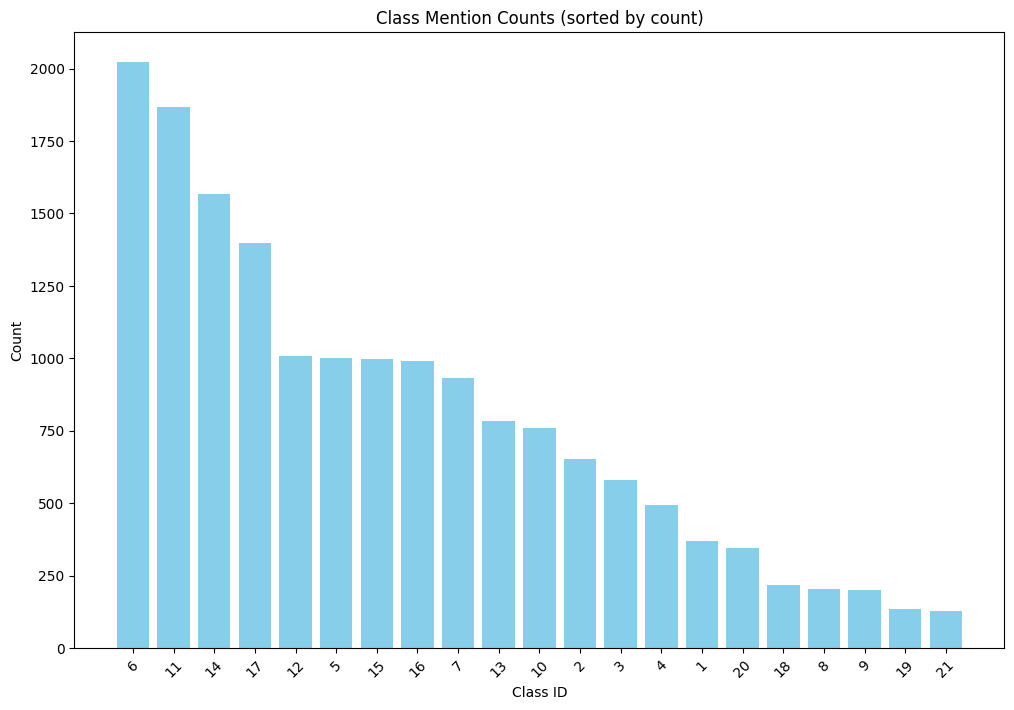

In [13]:
# Sort by count in descending order
sorted_class_counts = sorted(class_counts.items(), key=lambda item: item[1], reverse=True)

# Extract class IDs and counts for plotting
class_ids, counts = zip(*sorted_class_counts)

# Plotting the results
plt.figure(figsize=(12, 8))
plt.bar(class_ids, counts, color='skyblue')
plt.xlabel('Class ID')
plt.ylabel('Count')
plt.title('Class Mention Counts (sorted by count)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [14]:
index  = pd.read_excel("/home/najo/NAS/ONLAB/ONLAB_Competency/keyword-index.xlsx")

print(index)

                Name  Index
0            창의력을 가진      1
1         유연한 사고를 가진      2
2   데이터 기반의 의사결정을 하는      3
3       다양한 의견을 수렴하는      4
4        문제해결능력이 뛰어난      5
5    탄탄한 의사소통 능력을 가진      6
6       선한 영향력을 행사하는      7
7          다양성을 존중하는      8
8          신뢰를 주는 리더      9
9            적응력이 높은     10
10     지속적인 성장을 추구하는     11
11          비전을 제시하는     12
12     고도의 자기주도성을 가진     13
13      비즈니스 마인드를 갖춘     14
14       고도의 책임감을 가진     15
15              적극적인     16
16   목표를 달성하는 능력을 갖춘     17
17    자원을 효율적으로 활용하는     18
18     신속한 의사결정을 내리는     19
19       긍정적인 태도를 갖춘     20
20  위기 상황에서도 안정감을 주는     21
